In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

SEED = 42

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:

path = "D:/Fake_News_Detection/advanced model/data/IFND.csv"
df = pd.read_csv(path, encoding='ISO-8859-1')
print("Loaded:", path)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Loaded: D:/Fake_News_Detection/advanced model/data/IFND.csv
Shape: (56714, 7)
Columns: ['id', 'Statement', 'Image', 'Web', 'Category', 'Date', 'Label']


In [4]:

# Clean column names
df.columns = df.columns.str.lower()

text_col = 'statement'
label_col = 'label' if 'label' in df.columns else 'category'


def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = " ".join([w for w in text.split() if w not in stop_words])
    return text


df['text_clean'] = df[text_col].apply(clean_text)

df[label_col] = df[label_col].astype(str).str.lower().str.strip()
mapping = {'true': 1, 'fake': 0}
df[label_col] = df[label_col].map(mapping)
df = df.dropna(subset=[label_col])

print("\nLabel distribution before balancing:\n", df[label_col].value_counts())

true_df = df[df[label_col] == 1]
fake_df = df[df[label_col] == 0]

min_len = min(len(true_df), len(fake_df))
true_df = resample(true_df, replace=False, n_samples=min_len, random_state=SEED)
fake_df = resample(fake_df, replace=False, n_samples=min_len, random_state=SEED)

df_balanced = pd.concat([true_df, fake_df]).sample(frac=1, random_state=SEED)
print("\nBalanced label counts:\n", df_balanced[label_col].value_counts())

X = df_balanced['text_clean']
y = df_balanced[label_col].astype(int)


Label distribution before balancing:
 1    37800
0    18914
Name: label, dtype: int64

Balanced label counts:
 1    18914
0    18914
Name: label, dtype: int64


In [5]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
print("\nTrain size:", X_train.shape, "Test size:", X_test.shape)


Train size: (30262,) Test size: (7566,)


In [6]:
tfidf = TfidfVectorizer(max_features=25000, ngram_range=(1, 3), sublinear_tf=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)

TF-IDF shapes: (30262, 25000) (7566, 25000)



✅ Accuracy: 0.9261

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.87      0.92      3783
           1       0.89      0.98      0.93      3783

    accuracy                           0.93      7566
   macro avg       0.93      0.93      0.93      7566
weighted avg       0.93      0.93      0.93      7566



C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


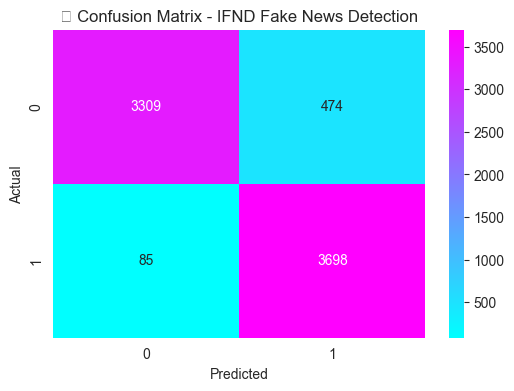


Baseline accuracy: 0.5
CV mean: 0.9286 std: 0.0044


In [7]:
lr = LogisticRegression(max_iter=500, C=3, random_state=SEED)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=25,
    random_state=SEED,
    class_weight='balanced'
)

ensemble = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf)],
    voting='soft'
)

ensemble.fit(X_train_tfidf, y_train)

y_pred = ensemble.predict(X_test_tfidf)

print("\n✅ Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='cool')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("🧩 Confusion Matrix - IFND Fake News Detection")
plt.show()

scores = cross_val_score(ensemble, tfidf.transform(X), y, cv=5, scoring='accuracy')
print("\nBaseline accuracy:", round(y.value_counts(normalize=True).max(), 4))
print("CV mean:", round(scores.mean(), 4), "std:", round(scores.std(), 4))


In [10]:

def predict_news(headline):
    clean = clean_text(headline)
    features = tfidf.transform([clean])
    pred = ensemble.predict(features)[0]
    prob = ensemble.predict_proba(features)[0][1]
    label = "REAL ✅" if pred == 1 else "FAKE ❌"
    print(f"\n📰 Headline: {headline}")
    print(f"🔎 Prediction: {label}")
    print(f"📊 Confidence: {prob:.2f}")


test_headlines = [
    "Government launches AI-powered scheme for students nationwide",
    "NASA confirms aliens have landed in Mumbai!",
    "Prime Minister announces new economic relief package",
    "Bollywood star claims to have met ghosts in hotel room",
    "Supreme Court bans plastic nationwide from next year",
    "Celebrity claims to time travel using quantum energy"
]

for h in test_headlines:
    predict_news(h)
    print("-" * 50)



📰 Headline: Government launches AI-powered scheme for students nationwide
🔎 Prediction: REAL ✅
📊 Confidence: 0.72
--------------------------------------------------

📰 Headline: NASA confirms aliens have landed in Mumbai!
🔎 Prediction: FAKE ❌
📊 Confidence: 0.46
--------------------------------------------------

📰 Headline: Prime Minister announces new economic relief package
🔎 Prediction: REAL ✅
📊 Confidence: 0.77
--------------------------------------------------

📰 Headline: Bollywood star claims to have met ghosts in hotel room
🔎 Prediction: REAL ✅
📊 Confidence: 0.61
--------------------------------------------------

📰 Headline: Supreme Court bans plastic nationwide from next year
🔎 Prediction: REAL ✅
📊 Confidence: 0.78
--------------------------------------------------

📰 Headline: Celebrity claims to time travel using quantum energy
🔎 Prediction: FAKE ❌
📊 Confidence: 0.38
--------------------------------------------------


In [82]:
import joblib


In [83]:
# Save the TF-IDF vectorizer and the trained ensemble model
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(ensemble, "fake_news_model.pkl")

print("\n✅ Model and vectorizer saved successfully!")



✅ Model and vectorizer saved successfully!
